In [5]:
import os
import re
from pathlib import Path
from datetime import datetime
import cv2
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
# CONFIG 
TOP_MASK_DIR = Path("masks/cam1_masks")
SIDE_MASK_DIR = Path("masks/cam0_masks")
OUTPUT_DIR = Path("Df_created_from_images")
YEAR = 2025

# pixel scales
PX_PER_MM = {
    'top': 26.242,
    'side': 16.586,
}

# output file
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = OUTPUT_DIR / "scoby_volume.csv"

In [3]:
# regex for timestamp: MM-DD_HH-MM
_ts_re = re.compile(r"(\d{2})-(\d{2})_(\d{2})-(\d{2})")

def parse_timestamp(fname: str) -> datetime:
    m = _ts_re.search(fname)
    if not m:
        raise ValueError(f"Invalid timestamp in filename: {fname}")
    month, day, hour, minute = map(int, m.groups())
    return datetime(YEAR, month, day, hour, minute)

# collect side masks keyed by timestamp
side_map = {}
for path in SIDE_MASK_DIR.glob("*.png"):
    try:
        ts = parse_timestamp(path.name)
        side_map[ts] = path
    except ValueError:
        print(f"[WARN] skipping side file: {path.name}")

# process masks and compute metrics
records = []
for top_path in sorted(TOP_MASK_DIR.glob("*.png")):
    try:
        ts = parse_timestamp(top_path.name)
        side_path = side_map.get(ts)
        if side_path is None:
            print(f"[WARN] no side for {top_path.name}")
            continue

        # load masks
        top_mask = cv2.imread(str(top_path), cv2.IMREAD_GRAYSCALE) > 0
        side_mask = cv2.imread(str(side_path), cv2.IMREAD_GRAYSCALE) > 0

        # compute area (px^2) & mean thickness (px)
        area_px2 = int(top_mask.sum())
        thickness_px = float(side_mask.sum(axis=0).mean())

        # convert & volume
        area_mm2 = area_px2 / PX_PER_MM['top']**2
        thickness_mm = thickness_px / PX_PER_MM['side']
        volume_mm3 = area_mm2 * thickness_mm

        records.append({
            'timestamp': ts,
            'area_mm2': area_mm2,
            'thickness_mm': thickness_mm,
            'volume_mm3': volume_mm3,
        })

    except Exception as e:
        print(f"[ERROR] {top_path.name}: {e}")

# save DataFrame
df = pd.DataFrame(records).sort_values('timestamp').reset_index(drop=True)
df.to_csv(CSV_PATH, index=False)
print(f"Saved results to {CSV_PATH} ({len(df)} entries)")

Saved results to Df_created_from_images\scoby_volume.csv (345 entries)


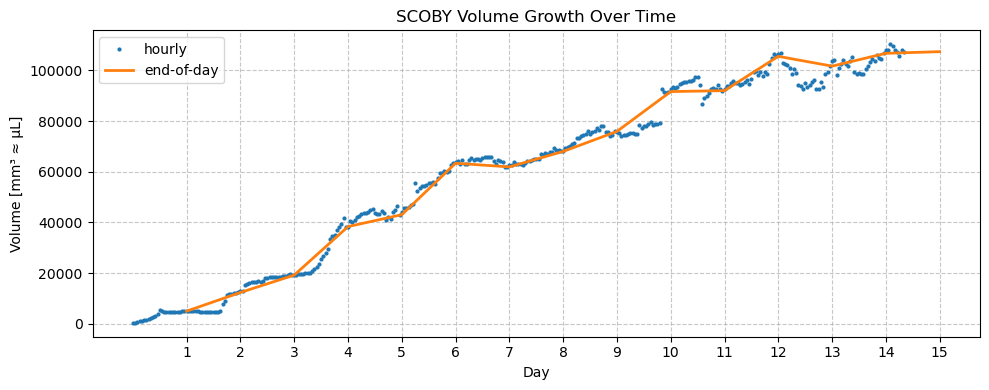

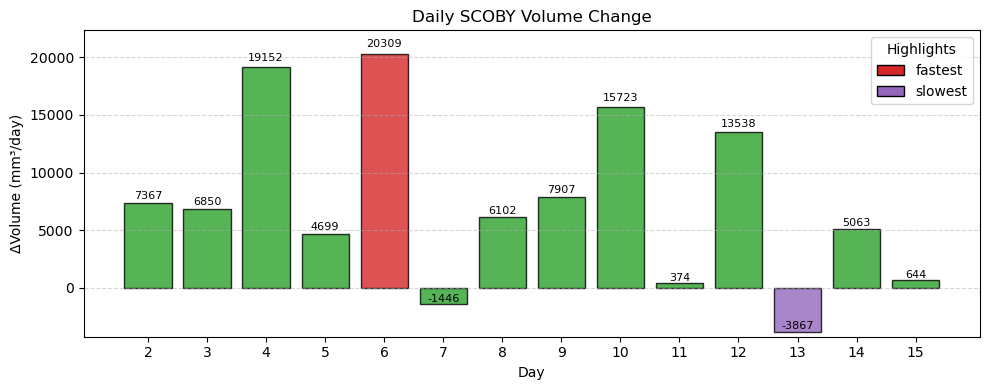

In [6]:
# PLOTTING
# prepare time axes
df['timestamp'] = pd.to_datetime(df['timestamp'])
start = df['timestamp'].min()
df['day_frac'] = (df['timestamp'] - start).dt.total_seconds() / (24*3600)
df['day_int'] = df['day_frac'].astype(int) + 1

daily = df.groupby('day_int')['volume_mm3'].last()

daily_diff = daily.diff().dropna()
best = daily_diff.idxmax()
worst = daily_diff.idxmin()

# -- Volume growth plot --
plt.figure(figsize=(10, 4))
plt.plot(df['day_frac'], df['volume_mm3'], '.', markersize=4, lw=0.8, label='hourly')
plt.plot(daily.index, daily.values, lw=2, label='end-of-day')
plt.xlabel('Day')
plt.ylabel('Volume [mm³ ≈ µL]')
plt.title('SCOBY Volume Growth Over Time')
plt.xticks(range(1, df['day_int'].max() + 1))
plt.grid(which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# -- Daily change plot --
fig, ax = plt.subplots(figsize=(10, 4))
colors = ['C2'] * len(daily_diff)
colors[list(daily_diff.index).index(best)] = 'C3'
colors[list(daily_diff.index).index(worst)] = 'C4'
bars = ax.bar(daily_diff.index, daily_diff.values, color=colors, edgecolor='k', alpha=0.8)
for bar in bars:
    x = bar.get_x() + bar.get_width() / 2
    h = bar.get_height()
    ax.text(x, h * 1.02 if h >= 0 else h * 0.98, f'{h:.0f}', ha='center', va='bottom', fontsize=8)

legend = [Patch(facecolor='C3', edgecolor='k', label='fastest'),
          Patch(facecolor='C4', edgecolor='k', label='slowest')]
ax.legend(handles=legend, title='Highlights', loc='upper right')
ax.set_xlabel('Day')
ax.set_ylabel('ΔVolume (mm³/day)')
ax.set_title('Daily SCOBY Volume Change')
ax.set_xticks(daily_diff.index)
ax.set_ylim(daily_diff.min() * 1.1, daily_diff.max() * 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Thickness

In [7]:
# Daily Area vs. Thickness Profile
df = pd.read_csv(CSV_PATH, parse_dates=["timestamp"])

# compute day index
t0 = df["timestamp"].min()
df["day_int"] = ((df["timestamp"] - t0)
                  .dt.total_seconds() / (24 * 3600)).astype(int) + 1

# clean thickness: zeros → NaN, optional minimum threshold
df["thickness_clean"] = df["thickness_mm"].replace(0, np.nan)
MIN_DETECT = 0.5
df.loc[df["thickness_clean"] < MIN_DETECT, "thickness_clean"] = np.nan

# daily summaries
daily = df.groupby("day_int").agg(
    area_mean    = ("area_mm2",        "mean"),
    area_std     = ("area_mm2",        "std"),
    thick_mean   = ("thickness_clean", "mean"),
    thick_std    = ("thickness_clean", "std"),
).reset_index()

# manual range
manual_min, manual_max = 5.0, 13.0

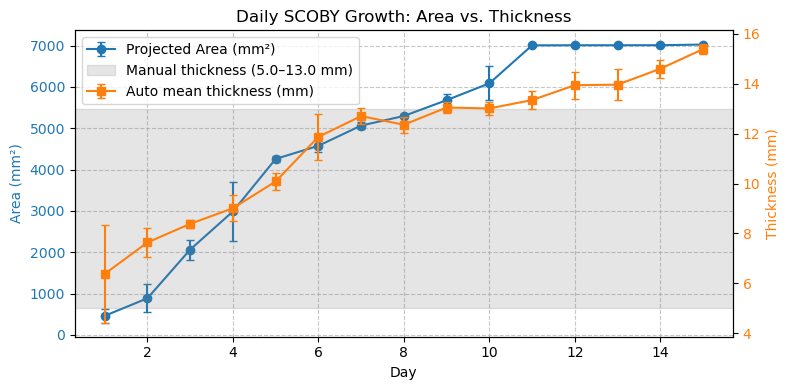

In [8]:
fig, ax1 = plt.subplots(figsize=(8,4))

# area on left axis (blue)
ax1.errorbar(
    daily["day_int"], daily["area_mean"],
    yerr=daily["area_std"], fmt='-o', color='tab:blue', capsize=3,
    label="Projected Area (mm²)", zorder=3
)
ax1.set_xlabel("Day")
ax1.set_ylabel("Area (mm²)", color='tab:blue')
ax1.tick_params(axis="y", labelcolor='tab:blue')
ax1.grid(True, which="both", linestyle="--", alpha=0.7)

# thickness on right axis (orange)
ax2 = ax1.twinx()
ax2.axhspan(
    manual_min, manual_max,
    color='tab:gray', alpha=0.2,
    label=f"Manual thickness ({manual_min}–{manual_max} mm)",
    zorder=1
)
ax2.errorbar(
    daily["day_int"], daily["thick_mean"],
    yerr=daily["thick_std"], fmt='-s', color='tab:orange', capsize=3,
    label="Auto mean thickness (mm)", zorder=4
)
ax2.set_ylabel("Thickness (mm)", color='tab:orange')
ax2.tick_params(axis="y", labelcolor='tab:orange')

# combined legend & title
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Daily SCOBY Growth: Area vs. Thickness")
plt.tight_layout()
plt.show()


## Bubbles Analyse

In [9]:
# ----------------------
# CONFIG
# ----------------------
# Side‐view timelapse folder
CAM0_DIR = Path("data/Experiment_6/exp6_cam0/exp6_cam0_cropped_small_14d")
# where to save results
OUTPUT_DIR = Path("Df_created_from_images")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# scale & timing
SIDE_SCALE_PX_PER_MM = 16.586       # px per mm for side camera
FRAME_INTERVAL_S     = 3600         # seconds between consecutive frames

# load the volume df for timestamp syncing
df_vol = pd.read_csv(
    OUTPUT_DIR / "scoby_volume.csv",
    parse_dates=["timestamp"]
).sort_values("timestamp").reset_index(drop=True)

In [10]:
# helper: ROI mask functions
# baseline for scoby detection
baseline_bgr = cv2.imread(str(sorted(CAM0_DIR.glob("*.jpg"))[0]))
baseline_L   = cv2.cvtColor(baseline_bgr, cv2.COLOR_BGR2LAB)[:, :, 0]

def scoby_mask(frame_bgr):
    L = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2LAB)[:, :, 0]
    diff = cv2.absdiff(L, baseline_L)
    _, m = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    m = cv2.medianBlur(m, 5)
    return cv2.morphologyEx(m, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8))

def strip_regions(mask):
    h, w = mask.shape
    mask[:, :35] = 0
    mask[:, -62:] = 0
    bot = int(h * (1 - 0.08))
    mid_lo, mid_hi = int(w*0.30), int(w*0.70)
    mask[bot:, mid_lo:mid_hi] = 0
    return mask

In [ ]:

# 1) gather frames
cam0_paths = sorted(CAM0_DIR.glob("cam0_*.jpg"))
assert len(cam0_paths) > 1, "Need at least two side‐view frames"


# 2) detect bubbles & record
bubble_records = []
prev_centroids = None

for idx in tqdm.tqdm(range(len(cam0_paths)-1), desc="Detecting bubbles"):
    img1 = cv2.imread(str(cam0_paths[idx]))
    img2 = cv2.imread(str(cam0_paths[idx+1]))
    # ROI
    m1 = strip_regions(scoby_mask(img1))
    g1, g2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    roi1 = cv2.bitwise_and(g1, g1, mask=m1)
    roi2 = cv2.bitwise_and(g2, g2, mask=m1)
    # motion
    diff = cv2.absdiff(roi2, roi1)
    _, motion = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)
    motion = cv2.morphologyEx(motion, cv2.MORPH_OPEN,  np.ones((3,3),np.uint8))
    motion = cv2.morphologyEx(motion, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8))
    # Hough circles
    circles = cv2.HoughCircles(
        motion, cv2.HOUGH_GRADIENT, dp=1.2, minDist=10,
        param1=50, param2=15, minRadius=3, maxRadius=30
    )
    # sync timestamp & day
    ts = df_vol.loc[idx, "timestamp"]
    day_float = (ts - df_vol["timestamp"].min()).total_seconds()/(24*3600)
    # unpack circles
    if circles is not None:
        circs = np.round(circles[0]).astype(int)
        cents = [(x,y) for x,y,_ in circs]
        diam_px = [2*r for *_,r in circs]
        diam_mm = [d/SIDE_SCALE_PX_PER_MM for d in diam_px]
        # velocity
        if prev_centroids:
            tree = cKDTree(cents)
            dists,_ = tree.query(prev_centroids, k=1)
            vel = np.mean(dists)/SIDE_SCALE_PX_PER_MM/FRAME_INTERVAL_S
        else:
            vel = np.nan
        prev_centroids = cents
        count = len(circs)
    else:
        count = 0; diam_mm = []; vel = np.nan; prev_centroids = None

    bubble_records.append({
        "frame_idx": idx,
        "timestamp": ts,
        "day_float": day_float,
        "count": count,
        "diam_mean_mm": np.nanmean(diam_mm) if diam_mm else np.nan,
        "diam_std_mm":  np.nanstd(diam_mm)  if diam_mm else np.nan,
        "vel_mean_mm_s": vel
    })

# build & save DataFrame
df_bub = pd.DataFrame(bubble_records)
# smooth the count (rolling window of 5)
df_bub["count_smooth"] = df_bub["count"].rolling(5, center=True, min_periods=1).mean()
df_bub.to_csv(OUTPUT_DIR/"bubble_kinetics.csv", index=False)


# 3) clean & filter

# remove early lag (first 6h)
df_bub = df_bub[df_bub["day_float"] >= 6/24.0].copy()
# physical limits
df_bub.loc[df_bub["diam_mean_mm"] > 5,    "diam_mean_mm"] = np.nan
df_bub.loc[df_bub["vel_mean_mm_s"] > 0.02,"vel_mean_mm_s"] = np.nan
# zero‐count cleanup
mask = (df_bub["count"] == 0) & df_bub["diam_mean_mm"].notna()
df_bub.loc[mask, ["diam_mean_mm","diam_std_mm","vel_mean_mm_s"]] = np.nan

Detecting bubbles: 100%|██████████| 344/344 [01:26<00:00,  3.98it/s]


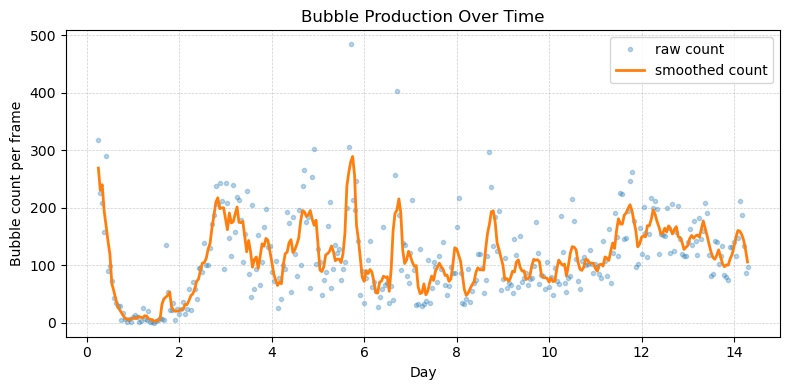

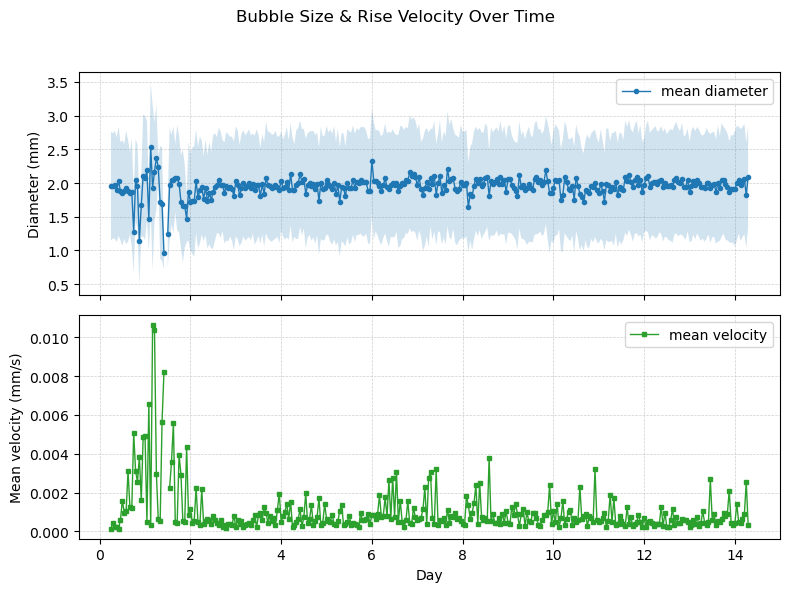

In [ ]:

#Bubble count 
plt.figure(figsize=(8,4))
plt.plot(df_bub["day_float"], df_bub["count"],      '.', alpha=0.3, label="raw count", zorder=2)
plt.plot(df_bub["day_float"], df_bub["count_smooth"], '-', lw=2, label="smoothed count", zorder=3)
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plt.xlabel("Day")
plt.ylabel("Bubble count per frame")
plt.title("Bubble Production Over Time")
plt.legend()
plt.tight_layout()
plt.show()

#  Mean diameter & velocity 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6), sharex=True)
# diameter
ax1.plot(df_bub["day_float"], df_bub["diam_mean_mm"],
         marker='o', ms=3, lw=1, label="mean diameter", zorder=3)
ax1.fill_between(df_bub["day_float"],
                 df_bub["diam_mean_mm"] - df_bub["diam_std_mm"],
                 df_bub["diam_mean_mm"] + df_bub["diam_std_mm"],
                 alpha=0.2, zorder=2)
ax1.set_ylabel("Diameter (mm)")
ax1.legend()
# velocity
ax2.plot(df_bub["day_float"], df_bub["vel_mean_mm_s"],
         marker='s', ms=3, lw=1, color='tab:green', label="mean velocity", zorder=3)
ax2.set_ylabel("Mean velocity (mm/s)")
ax2.set_xlabel("Day")
ax2.legend()
for a in (ax1, ax2):
    a.set_axisbelow(True)
    a.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plt.suptitle("Bubble Size & Rise Velocity Over Time")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
